## NCF

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
import scipy.sparse
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [3]:
train_clicked = pd.read_csv('train_clicked.csv')
train_not_clicked = pd.read_csv('train_not_clicked.csv')
val_clicked = pd.read_csv('val_clicked.csv')
val_not_clicked = pd.read_csv('val_not_clicked.csv')

news_data = pd.read_csv('small_full_news.csv')

In [4]:
train = pd.concat([train_clicked, train_not_clicked]).sort_values(by = ['user_id', 'timestamp']).drop(columns = 'timestamp')
val = pd.concat([val_clicked, val_not_clicked]).sort_values(by = ['user_id', 'timestamp']).drop(columns = 'timestamp')
# entity_emb = pd.concat([train_entity_emb, val_entity_emb]).sort_values(by = [0]).drop_duplicates(subset = [0], keep = 'last')

In [197]:
behaviors_train = pd.read_csv("train_behaviors.tsv", sep='\t', 
                        names = ['impression_id', 'user_id', 'timestamp', 'history', 'impressions'])
behaviors_val = pd.read_csv("val_behaviors.tsv", sep = '\t',
                           names = ['impression_id', 'user_id', 'timestamp', 'history', 'impressions'])

In [198]:
history_train = behaviors_train[['user_id', 'history']]
history_val = behaviors_val[['user_id', 'history']]

In [199]:
history_train['history'] = history_train['history'].str.split()
history_train = history_train.explode('history')
history_train['impression'] = 1

In [97]:
history_train = history_train.dropna(subset=['history'])

In [98]:
# removing N from news_ids and U from user_id
history_train['news_id'] = history_train['history'].str.replace('N', '').astype(int)
history_train['user_id'] = history_train['user_id'].str.replace('U', '').astype(int)
history_train = history_train.drop(columns = 'history')

### Data Cleaning

In [5]:
print("Shape: ", train.shape)
print("Duplicates:", train.duplicated().sum())
print("Missing values:", train.isna().sum().sum())
train.head()

Shape:  (5843444, 3)
Duplicates: 809569
Missing values: 0


,user_id,news_id,impression
141483,2,20079,1
3359706,2,33619,0
206648,2,31978,1
206649,2,57809,1
4901716,2,20527,0


In [6]:
print("Shape: ", val.shape)
print("Duplicates:", val.duplicated().sum())
print("Missing values:", val.isna().sum().sum())
val.head()

Shape:  (2740998, 3)
Duplicates: 262434
Missing values: 0


,user_id,news_id,impression
12532,1,20036,1
294411,1,14637,0
37078,3,63964,1
37079,3,52714,1
870454,3,44772,0


In [7]:
print("Duplicate articles:", news_data.duplicated().sum())
print("Duplicate titles:", news_data['title'].duplicated().sum())
print("Duplicate abstracts:", news_data['abstract'].duplicated().sum())
print("Empty titles:", news_data['title'].isna().sum())
print("Empty abstracts:", news_data['abstract'].isna().sum())
news_data.head()

Duplicate articles: 0
Duplicate titles: 1313
Duplicate abstracts: 5398
Empty titles: 0
Empty abstracts: 3415


,news_id,category,subcategory,title,abstract,title_entities,abstract_entities
0,55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...","[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",[],"[{""Label"": ""National Basketball Association"", ..."
4,38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [103]:
news_data['abstract'] = news_data['abstract'].fillna('None')

In [104]:
news_data[news_data['abstract_entities'].apply(lambda x: x == '[]')]

,news_id,category,subcategory,title,abstract,title_entities,abstract_entities
0,55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...","[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
8,24510,entertainment,gaming,Best PS5 games: top PlayStation 5 titles to lo...,Every confirmed or expected PS5 game we can't ...,"[{""Label"": ""PlayStation"", ""Type"": ""J"", ""Wikida...",[]
10,9721,health,nutrition,"50 Foods You Should Never Eat, According to He...",This is so depressing.,[],[]
12,39758,health,nutrition,25 Biggest Grocery Store Mistakes Making You G...,From picking up free goodies to navigating the...,"[{""Label"": ""Weight gain"", ""Type"": ""C"", ""Wikida...",[]
13,28361,health,wellness,Instagram Filters with Plastic Surgery-Inspire...,In an effort to combat some of the negative me...,"[{""Label"": ""Instagram"", ""Type"": ""W"", ""Wikidata...",[]
...,...,...,...,...,...,...,...
65223,13123,sports,football_nfl,"Colts News: Colts' Eric Ebron frustrated, seek...",None,"[{""Label"": ""Indianapolis Colts"", ""Type"": ""O"", ...",[]
65226,2661,sports,basketball_ncaa,"Girls soccer scoreboard: Class AA, A, B state ...",Class C Haldane has already booked a trip to t...,"[{""Label"": ""Double-A (baseball)"", ""Type"": ""U"",...",[]
65228,898,sports,football_nfl,Cardinals are a now 4.5-point underdog vs. the...,None,"[{""Label"": ""Arizona Cardinals"", ""Type"": ""O"", ""...",[]
65232,53002,sports,football_nfl,Twitter reacts to Chargers' loss to Raiders,None,"[{""Label"": ""Oakland Raiders"", ""Type"": ""O"", ""Wi...",[]


In [105]:
news_data.shape

(65238, 7)

### Data Preprocessing

#### Encoding User and Article IDs

In [106]:
user_encoder = LabelEncoder()
news_encoder = LabelEncoder()

In [107]:
all_user_ids = list(set(list(train['user_id']) + list(val['user_id'])))
user_encoder.fit(all_user_ids)

LabelEncoder()

In [108]:
all_news_ids = list(set(news_data['news_id']))
news_encoder.fit(all_news_ids)

LabelEncoder()

In [109]:
# encoding user and news ids
train['user_id_encoded'] = user_encoder.transform(train['user_id'])
train['news_id_encoded'] = news_encoder.transform(train['news_id'])
val['user_id_encoded'] = user_encoder.transform(val['user_id'])
val['news_id_encoded'] = news_encoder.transform(val['news_id'])

#### Encoding Category and Subcategory

In [110]:
cat_subcat_encoder = OneHotEncoder()
cat_subcat = cat_subcat_encoder.fit_transform(news_data[['category', 'subcategory']])

In [111]:
emb_dim = 18
cat_subcat_pca = PCA(n_components = emb_dim, random_state = 42)
cat_subcat_reduced = cat_subcat_pca.fit_transform(cat_subcat)

In [112]:
cat_subcat_df = pd.DataFrame(cat_subcat_reduced, columns = [f'cat_subcat_PC{i}' for i in range(emb_dim)])

In [173]:
metadata = pd.concat([news_data['news_id'], cat_subcat_df], axis = 1)
metadata.head()

,news_id,cat_subcat_PC0,cat_subcat_PC1,cat_subcat_PC2,cat_subcat_PC3,cat_subcat_PC4,cat_subcat_PC5,cat_subcat_PC6,cat_subcat_PC7,cat_subcat_PC8,cat_subcat_PC9,cat_subcat_PC10,cat_subcat_PC11,cat_subcat_PC12,cat_subcat_PC13,cat_subcat_PC14,cat_subcat_PC15,cat_subcat_PC16,cat_subcat_PC17
0,55528,-0.040326,-0.491364,0.040112,-0.108878,0.049649,-0.060767,0.024752,0.111237,0.856311,0.169498,-0.204650,-0.078405,-0.006506,0.000724,-0.001322,-0.006495,-0.011219,-0.039711
1,19639,-0.038699,-0.446291,0.027914,-0.068183,0.028403,-0.027908,0.010278,0.039107,0.103328,-0.220980,0.308430,0.848502,-0.025982,0.002438,-0.004048,-0.017461,-0.030426,-0.109772
2,61837,0.662918,0.161972,-0.434913,0.041245,-0.009890,0.004827,-0.001470,-0.004213,-0.003967,-0.220438,-0.152643,-0.002521,0.826361,0.001113,-0.001490,-0.389704,0.002376,-0.004756
3,53526,-0.038735,-0.447327,0.028233,-0.069297,0.029013,-0.029182,0.011811,0.040159,0.121647,-0.209939,0.293826,0.820371,-0.025310,0.002376,-0.003946,-0.016977,-0.029523,-0.106340
4,38324,-0.039463,-0.464400,0.030578,-0.075479,0.031661,-0.031482,0.011636,0.044501,0.119254,-0.263982,0.369273,1.040080,-0.033491,0.003197,-0.005397,-0.024926,-0.044661,-0.164167


#### Title and Abstract Embeddings

In [115]:
news_data['title'] = news_data['title'].fillna('')
news_data['abstract'] = news_data['abstract'].fillna('')
descriptions = news_data['title'].str.cat(news_data['abstract'], sep = ' ').tolist()

In [48]:
title_transformer = SentenceTransformer('all-MiniLM-L6-v2')
title_abs_embs = title_transformer.encode(descriptions, convert_to_numpy = True, show_progress_bar = True)

Batches:   0%|          | 0/2039 [00:00<?, ?it/s]

In [174]:
emb_dim = 20
title_abs_pca = PCA(n_components = emb_dim, random_state = 42)
reduced_title_abs_embs = title_abs_pca.fit_transform(title_abs_embs)
title_abs_df = pd.DataFrame(reduced_title_abs_embs, 
                                   columns=[f'title_abs_PC{i}' for i in range(emb_dim)])
metadata = pd.concat([metadata, title_abs_df], axis = 1)

In [175]:
metadata.head()

,news_id,cat_subcat_PC0,cat_subcat_PC1,cat_subcat_PC2,cat_subcat_PC3,cat_subcat_PC4,cat_subcat_PC5,cat_subcat_PC6,cat_subcat_PC7,cat_subcat_PC8,...,title_abs_PC10,title_abs_PC11,title_abs_PC12,title_abs_PC13,title_abs_PC14,title_abs_PC15,title_abs_PC16,title_abs_PC17,title_abs_PC18,title_abs_PC19
0,55528,-0.040326,-0.491364,0.040112,-0.108878,0.049649,-0.060767,0.024752,0.111237,0.856311,...,0.125444,0.026614,0.097965,-0.040697,0.027173,-0.018458,-0.013200,-0.046014,0.023905,0.033875
1,19639,-0.038699,-0.446291,0.027914,-0.068183,0.028403,-0.027908,0.010278,0.039107,0.103328,...,-0.086111,0.025917,-0.109475,-0.065841,-0.092103,0.046736,-0.013036,0.006105,-0.055702,-0.025988
2,61837,0.662918,0.161972,-0.434913,0.041245,-0.009890,0.004827,-0.001470,-0.004213,-0.003967,...,-0.101847,-0.029639,-0.040886,0.058671,0.068492,0.006319,-0.019241,-0.051025,0.154597,0.011135
3,53526,-0.038735,-0.447327,0.028233,-0.069297,0.029013,-0.029182,0.011811,0.040159,0.121647,...,0.108604,-0.002461,0.200067,-0.068349,-0.160759,-0.017299,-0.009352,-0.058660,0.002720,-0.070573
4,38324,-0.039463,-0.464400,0.030578,-0.075479,0.031661,-0.031482,0.011636,0.044501,0.119254,...,0.185135,0.002427,-0.156603,-0.018753,-0.048545,0.099675,-0.023849,-0.052315,-0.052314,0.014100


#### Embeddings in Dataset (Did Not Improve Performance)

In [ ]:
# train_entity_emb = train_entity_emb.drop(columns = [101])
# train_entity_emb = train_entity_emb.rename(columns = {0: 'entity_id'}).set_index('entity_id')
# train_entity_emb.head()

In [ ]:
# val_entity_emb = val_entity_emb.drop(columns = [101])
# val_entity_emb = val_entity_emb.rename(columns = {0: 'entity_id'}).set_index('entity_id')
# val_entity_emb.head()

In [ ]:
# all_entities_emb = pd.concat([train_entity_emb, val_entity_emb]).drop_duplicates()
# all_entities_emb.head()

In [ ]:
# import json

In [ ]:
# # replacing any NaN values in title_entities and abstract_entities columns with empty list string '[]'
# news_data['title_entities'] = news_data['title_entities'].apply(
#     lambda x: '[]' if pd.isna(x) else x)
# news_data['abstract_entities'] = news_data['abstract_entities'].apply(
#     lambda x: '[]' if pd.isna(x) else x)

In [ ]:
# # getting entity ids for titles
# title_wikidata_ids = []

# for i, row in news_data.iterrows():
#     title_entities = json.loads(row['title_entities'])
#     n_ids = [e['WikidataId'] for e in title_entities]     
#     title_wikidata_ids.append(n_ids)

# news_data['title_entities_ids'] = title_wikidata_ids
# news_data.head()

In [ ]:
# # getting entity ids for abstracts
# abstract_wikidata_ids = []

# for i, row in news_data.iterrows():
#     abstract_entities = json.loads(row['abstract_entities'])
#     n_ids = [e['WikidataId'] for e in abstract_entities]     
#     abstract_wikidata_ids.append(n_ids)

# news_data['abstract_entities_ids'] = abstract_wikidata_ids
# news_data.head()

In [ ]:
# # wikidata id to embedding mapping
# embedding_dict = {
#     entity_id: row.values for entity_id, row in all_entities_emb.iterrows()
# }

In [ ]:
# # calculating entity weights
# from collections import Counter

# # flattening all entity lists and counting how many times each one shows up
# all_entity_ids = news_data['title_entities_ids'].explode().dropna().tolist()
# entity_freq = Counter(all_entity_ids)

# # normalizing to get probabilities
# total = sum(entity_freq.values())
# entity_weights = {e_id: freq / total for e_id, freq in entity_freq.items()}

In [ ]:
# # combines title and abstract embeddings and returns 100dim vector for each article (if it has entities)
# def get_weighted_article_embedding(entity_ids, embedding_dict, weight_dict, dim = 100):
#     vectors = []
#     weights = []
#     for e_id in entity_ids:
#         if e_id in embedding_dict:
#             vectors.append(embedding_dict[e_id])
#             weights.append(weight_dict.get(e_id, 1e-3)) #add small default weight if no weight found
    
#     if not vectors:
#         return np.zeros(dim)
#     return np.average(vectors, axis = 0, weights = weights)

In [ ]:
# news_data['title_abstract_embedding'] = news_data.apply(
#     lambda row: get_weighted_article_embedding(
#         (row['title_entities_ids'] or []) + (row['abstract_entities_ids'] or []),
#         embedding_dict, entity_weights).astype(np.float32),
#     axis=1
# )

In [ ]:
# metadata['title_abstract_embedding'] = news_data['title_abstract_embedding']

In [ ]:
# metadata.head()

#### Sentiment Analysis

In [51]:
from textblob import TextBlob

In [200]:
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    return polarity

In [119]:
title_sents = news_data['title'].apply(get_sentiment)
news_data['title_sents'] = title_sents
abs_sents = news_data['abstract'].apply(get_sentiment)
news_data['abs_sents'] = abs_sents

In [176]:
metadata = metadata.merge(news_data[['news_id', 'title_sents', 'abs_sents']], on = 'news_id', how = 'left')

In [177]:
metadata.head()

,news_id,cat_subcat_PC0,cat_subcat_PC1,cat_subcat_PC2,cat_subcat_PC3,cat_subcat_PC4,cat_subcat_PC5,cat_subcat_PC6,cat_subcat_PC7,cat_subcat_PC8,...,title_abs_PC12,title_abs_PC13,title_abs_PC14,title_abs_PC15,title_abs_PC16,title_abs_PC17,title_abs_PC18,title_abs_PC19,title_sents,abs_sents
0,55528,-0.040326,-0.491364,0.040112,-0.108878,0.049649,-0.060767,0.024752,0.111237,0.856311,...,0.097965,-0.040697,0.027173,-0.018458,-0.013200,-0.046014,0.023905,0.033875,0.0,0.318182
1,19639,-0.038699,-0.446291,0.027914,-0.068183,0.028403,-0.027908,0.010278,0.039107,0.103328,...,-0.109475,-0.065841,-0.092103,0.046736,-0.013036,0.006105,-0.055702,-0.025988,-1.0,0.350000
2,61837,0.662918,0.161972,-0.434913,0.041245,-0.009890,0.004827,-0.001470,-0.004213,-0.003967,...,-0.040886,0.058671,0.068492,0.006319,-0.019241,-0.051025,0.154597,0.011135,0.0,-0.033333
3,53526,-0.038735,-0.447327,0.028233,-0.069297,0.029013,-0.029182,0.011811,0.040159,0.121647,...,0.200067,-0.068349,-0.160759,-0.017299,-0.009352,-0.058660,0.002720,-0.070573,-0.1,0.100000
4,38324,-0.039463,-0.464400,0.030578,-0.075479,0.031661,-0.031482,0.011636,0.044501,0.119254,...,-0.156603,-0.018753,-0.048545,0.099675,-0.023849,-0.052315,-0.052314,0.014100,0.0,0.580000


### Training + Validation Sets

In [178]:
train_metadata = train.merge(metadata, on = 'news_id', how = 'left')
val_metadata = val.merge(metadata, on = 'news_id', how = 'left')

In [ ]:
batch_size = 1000000
chunks = []

for i in range(0, len(train), batch_size):
    chunk = train.iloc[i:i + batch_size]
    merged = chunk.merge(metadata, on = 'news_id', how = 'left')
    chunks.append(merged)

train_metadata = pd.concat(chunks, ignore_index=True)

In [ ]:
chunks = []

for i in range(0, len(val), batch_size):
    chunk = val.iloc[i:i + batch_size]
    merged = chunk.merge(metadata, on = 'news_id', how = 'left')
    chunks.append(merged)

val_metadata = pd.concat(chunks, ignore_index=True)

In [179]:
X_train = train_metadata.drop(columns = ['impression', 'user_id', 'news_id'])
y_train = train_metadata['impression']
X_val = val_metadata.drop(columns = ['impression', 'user_id', 'news_id'])
y_val = val_metadata['impression']

### Initial Model

In [58]:
def build_ncf_model(num_users, num_items, metadata_dim):
    # user tower
    user_input = Input(shape = (1, ), name = 'user_input')
    user_embedding = Embedding(input_dim = num_users, output_dim = 16, embeddings_regularizer=l2(1e-6))(user_input)
    user_vec = Flatten()(user_embedding)
    user_vec = Dense(64, activation = 'relu', kernel_regularizer=l2(1e-6))(user_vec)    

    # item tower
    item_input = Input(shape = (1, ), name = 'item_input')
    item_embedding = Embedding(input_dim = num_items, output_dim = 16, embeddings_regularizer=l2(1e-6))(item_input)
    item_vec = Flatten()(item_embedding)
    
    metadata_input = Input(shape = (metadata_dim, ), name = 'metadata_input')
    metadata_vec = Dense(64, activation = 'relu')(metadata_input)

    item_with_metadata = Concatenate()([item_vec, metadata_vec])
    item_with_metadata_vec = Dense(64, activation = 'relu', kernel_regularizer=l2(1e-6))(item_with_metadata)

    # interaction layer
    combined = Concatenate()([user_vec, item_with_metadata_vec])
    x = Dense(64, activation = 'relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation = 'sigmoid')(x)

    model = Model(inputs = [user_input, item_input, metadata_input], outputs = output)
    optimizer = Adam(learning_rate = 1e-4)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['AUC'])
    
    return model

In [201]:
# input extraction
cat_subcat_cols = [f'cat_subcat_PC{i}' for i in range(18)]
title_abs_cols = [f'title_abs_PC{i}' for i in range(10)]
title_sents_col = ['title_sents', 'abs_sents']

In [181]:
train_user_ids = X_train['user_id_encoded'].values
train_news_ids = X_train['news_id_encoded'].values
train_meta = X_train[cat_subcat_cols + title_abs_cols + title_sents_col].values.astype('float32')

In [182]:
val_user_ids = X_val['user_id_encoded'].values
val_news_ids = X_val['news_id_encoded'].values
val_meta = X_val[cat_subcat_cols + title_abs_cols + title_sents_col].values.astype('float32')

In [183]:
# input dimensions
num_users = val_metadata['user_id_encoded'].max()
num_items = train_metadata['news_id_encoded'].max()
metadata_dim = len(train_meta[0])

In [184]:
model = build_ncf_model(num_users + 1, num_items + 1, metadata_dim)

In [185]:
model.fit(
    x = [train_user_ids, train_news_ids, train_meta],
    y = y_train,
    validation_data = ([val_user_ids, val_news_ids, val_meta], y_val),
    epochs = 3,
    batch_size = 16384,
    callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True)]
)

Epoch 1/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - AUC: 0.7999 - loss: 0.4990 - val_AUC: 0.5476 - val_loss: 0.7732
Epoch 2/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - AUC: 0.9831 - loss: 0.1294 - val_AUC: 0.5574 - val_loss: 0.9434
Epoch 3/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - AUC: 0.9845 - loss: 0.1187 - val_AUC: 0.5608 - val_loss: 1.1066


In [186]:
y_pred = model.predict([val_user_ids, val_news_ids, val_meta])

85657/85657 ━━━━━━━━━━━━━━━━━━━━ 25s 295us/step


In [187]:
val_pred = val.copy()

In [188]:
val_pred['pred_impression'] = y_pred
val_pred['binary_pred'] = val_pred['pred_impression'].apply(lambda x: int(x >= 0.5))

In [189]:
val_pred.head()

,user_id,news_id,impression,user_id_encoded,news_id_encoded,pred_impression,binary_pred
12532,1,20036,1,0,20035,0.113741,0
294411,1,14637,0,0,14636,0.338262,0
37078,3,63964,1,2,63963,0.542238,1
37079,3,52714,1,2,52713,0.920974,1
870454,3,44772,0,2,44771,0.918083,1


In [190]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
y_act = val_pred['impression']
y_score = val_pred['pred_impression']
pred = val_pred['binary_pred']

print("Confusion Matrix: \n",confusion_matrix(y_act, pred))
print("ROC-AUC: ", roc_auc_score(y_act, y_score))
print("Accuracy: ", accuracy_score(y_act, pred))
print("Precision: ", precision_score(y_act, pred))
print("Recall: ", recall_score(y_act, pred))
print("F1: ", f1_score(y_act, pred))

Confusion Matrix: 
 [[1559581 1070034]
 [  60405   50978]]
ROC-AUC:  0.5476556427604562
Accuracy:  0.5875812386583281
Precision:  0.045474981534542006
Recall:  0.4576820520187102
F1:  0.08272996888173029


In [192]:
val_pred.groupby('binary_pred').count()

,user_id,news_id,impression,user_id_encoded,news_id_encoded,pred_impression
binary_pred,,,,,,
0,1619986,1619986,1619986,1619986,1619986,1619986
1,1121012,1121012,1121012,1121012,1121012,1121012


In [191]:
val_pred.groupby('impression').count()

,user_id,news_id,user_id_encoded,news_id_encoded,pred_impression,binary_pred
impression,,,,,,
0,2629615,2629615,2629615,2629615,2629615,2629615
1,111383,111383,111383,111383,111383,111383


### Title/Abstract Embedding Dimension Comparison

Comparing performance of NCF model with different dimensions for title/abstract encodings:

In [137]:
title_abs_embs

array([[-2.6684696e-02,  8.5728966e-02,  5.4504406e-02, ...,
        -9.8547913e-02,  4.4370119e-02, -1.9332731e-02],
       [ 2.8437618e-02,  3.3090316e-02,  6.2954023e-02, ...,
        -8.4096156e-03, -2.9258691e-02, -1.8736642e-02],
       [-2.0724498e-02,  1.2053244e-01,  4.4877954e-02, ...,
        -8.8807181e-02, -2.7464699e-05,  1.3815069e-02],
       ...,
       [ 7.9327814e-02,  7.6653160e-02, -2.6881650e-02, ...,
        -5.0289486e-02,  1.0427038e-02, -2.3070870e-02],
       [ 3.1078458e-02, -3.5006270e-02,  8.8226572e-02, ...,
         1.5736680e-02, -1.2567897e-01, -1.3109935e-03],
       [-1.0301259e-02,  7.2007645e-03,  1.0234008e-02, ...,
        -3.9484035e-02, -3.0965433e-02, -9.3319125e-02]], dtype=float32)

In [138]:
news_ids = news_data[['news_id']]

def get_title_abs_encodings(dimension):
    # reducing subcategories to `dimension` number of components
    title_abs_pca = PCA(n_components = dimension, random_state = 42)
    title_abs_reduced = title_abs_pca.fit_transform(title_abs_embs)
    title_abs_df = pd.DataFrame(title_abs_reduced, columns = [f'title_abs_PC{i}' for i in range(dimension)])
    title_abs_df = pd.concat([news_ids, title_abs_df], axis = 1)
    return title_abs_df

In [139]:
# inputs that do not change
cat_subcat_cols = [f'cat_subcat_PC{i}' for i in range(18)]
title_sents_col = ['title_sents', 'abs_sents']

train_user_ids = X_train['user_id_encoded'].values
train_news_ids = X_train['news_id_encoded'].values

val_user_ids = X_val['user_id_encoded'].values
val_news_ids = X_val['news_id_encoded'].values

num_users = val['user_id_encoded'].max()
num_items = train['news_id_encoded'].max()

In [140]:
static_meta = pd.concat([news_ids, cat_subcat_df], axis = 1)
static_meta['title_sents'] = news_data['title_sents']
static_meta['abs_sents'] = news_data['abs_sents']

static_train_meta = train.merge(static_meta, on = 'news_id', how = 'left')
static_val_meta = val.merge(static_meta, on = 'news_id', how = 'left')

def get_inputs(static_train_meta, static_val_meta, title_abs_df):
    # merging subcat columns
    static_train_meta = static_train_meta.merge(title_abs_df, on = 'news_id')
    static_val_meta = static_val_meta.merge(title_abs_df, on = 'news_id')
    
    # creating X and y training and validation datasets
    X_train = static_train_meta.drop(columns = ['impression', 'user_id', 'news_id'])
    X_val = static_val_meta.drop(columns = ['impression', 'user_id', 'news_id'])

    # input extraction
    title_abs_cols = [c for c in title_abs_df.columns if c != 'news_id']

    # training inputs
    train_meta = X_train[cat_subcat_cols + title_abs_cols + title_sents_col].values.astype('float32')

    # validation inputs
    val_meta = X_val[cat_subcat_cols + title_abs_cols + title_sents_col].values.astype('float32')

    # input dimensions
    metadata_dim = len(train_meta[0])

    return train_meta, val_meta, metadata_dim

In [141]:
y_train = static_train_meta['impression']
y_val = static_val_meta['impression']

#### Dimension = 10

In [142]:
title_abs_10 = get_title_abs_encodings(10)
train_meta_10, val_meta_10, metadata_dim_10 = get_inputs(static_train_meta, static_val_meta, title_abs_10)

In [143]:
model_10 = build_ncf_model(num_users + 1, num_items + 1, metadata_dim_10)

In [144]:
history_10 = model_10.fit(
                x = [train_user_ids, train_news_ids, train_meta_10],
                y = y_train,
                validation_data = ([val_user_ids, val_news_ids, val_meta_10], y_val),
                epochs = 3,
                batch_size = 16384,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True)]
            )

Epoch 1/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - AUC: 0.8080 - loss: 0.4878 - val_AUC: 0.5595 - val_loss: 0.8704
Epoch 2/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - AUC: 0.9830 - loss: 0.1300 - val_AUC: 0.5651 - val_loss: 1.1194
Epoch 3/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - AUC: 0.9844 - loss: 0.1189 - val_AUC: 0.5645 - val_loss: 1.2578


##### dim = 10 model
Epoch 1/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - AUC: 0.8080 - loss: 0.4878 - val_AUC: 0.5595 - val_loss: 0.8704
Epoch 2/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - AUC: 0.9830 - loss: 0.1300 - val_AUC: 0.5651 - val_loss: 1.1194
Epoch 3/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - AUC: 0.9844 - loss: 0.1189 - val_AUC: 0.5645 - val_loss: 1.2578

In [145]:
y_pred_10 = model_10.predict([val_user_ids, val_news_ids, val_meta_10])

85657/85657 ━━━━━━━━━━━━━━━━━━━━ 25s 293us/step


In [146]:
val_pred = val.copy()
val_pred['pred_impression_10'] = y_pred_10
val_pred['binary_pred_10'] = [1 if pred > 0.5 else 0 for pred in y_pred_10]

In [165]:
loss = {}
val_loss = {}

In [86]:
val_pred.to_csv('val_pred.csv', index = False)

In [166]:
loss[10] = history_10.history['loss']
val_loss[10] = history_10.history['val_loss']

In [ ]:
import pickle

In [ ]:
with open('loss.pkl', 'wb') as f:
    pickle.dump(loss, f)
with open('val_loss.pkl', 'wb') as f:
    pickle.dump(val_loss, f)

#### Dimension = 20

In [148]:
title_abs_20 = get_title_abs_encodings(20)
train_meta_20, val_meta_20, metadata_dim_20 = get_inputs(static_train_meta, static_val_meta, title_abs_20)

In [149]:
model_20 = build_ncf_model(num_users + 1, num_items + 1, metadata_dim_20)

In [150]:
history_20 = model_20.fit(
                x = [train_user_ids, train_news_ids, train_meta_20],
                y = y_train,
                validation_data = ([val_user_ids, val_news_ids, val_meta_20], y_val),
                epochs = 3,
                batch_size = 16384,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True)]
            )

Epoch 1/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - AUC: 0.7966 - loss: 0.5089 - val_AUC: 0.5468 - val_loss: 0.7098
Epoch 2/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - AUC: 0.9828 - loss: 0.1310 - val_AUC: 0.5548 - val_loss: 0.6524
Epoch 3/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - AUC: 0.9843 - loss: 0.1199 - val_AUC: 0.5586 - val_loss: 0.6263


##### dim = 20 model
Epoch 1/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - AUC: 0.7966 - loss: 0.5089 - val_AUC: 0.5468 - val_loss: 0.7098
Epoch 2/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - AUC: 0.9828 - loss: 0.1310 - val_AUC: 0.5548 - val_loss: 0.6524
Epoch 3/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - AUC: 0.9843 - loss: 0.1199 - val_AUC: 0.5586 - val_loss: 0.6263

In [151]:
y_pred_20 = model_20.predict([val_user_ids, val_news_ids, val_meta_20])
val_pred['pred_impression_20'] = y_pred_20
val_pred['binary_pred_20'] = [1 if pred > 0.5 else 0 for pred in y_pred_20]

85657/85657 ━━━━━━━━━━━━━━━━━━━━ 25s 296us/step


In [152]:
val_pred.to_csv('val_pred.csv', index = False)

In [167]:
loss[20] = history_20.history['loss']
val_loss[20] = history_20.history['val_loss']

In [ ]:
with open('loss.pkl', 'wb') as f:
    pickle.dump(loss, f)
with open('val_loss.pkl', 'wb') as f:
    pickle.dump(val_loss, f)

#### Dimension = 50

In [153]:
title_abs_50 = get_title_abs_encodings(50)
train_meta_50, val_meta_50, metadata_dim_50 = get_inputs(static_train_meta, static_val_meta, title_abs_50)

In [154]:
model_50 = build_ncf_model(num_users + 1, num_items + 1, metadata_dim_50)

In [155]:
history_50 = model_50.fit(
                x = [train_user_ids, train_news_ids, train_meta_50],
                y = y_train,
                validation_data = ([val_user_ids, val_news_ids, val_meta_50], y_val),
                epochs = 3,
                batch_size = 16384,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True)]
            )

Epoch 1/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - AUC: 0.7985 - loss: 0.5010 - val_AUC: 0.5332 - val_loss: 0.8343
Epoch 2/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - AUC: 0.9831 - loss: 0.1299 - val_AUC: 0.5378 - val_loss: 1.0343
Epoch 3/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - AUC: 0.9845 - loss: 0.1187 - val_AUC: 0.5472 - val_loss: 1.1624


##### dim = 50 model
Epoch 1/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - AUC: 0.7985 - loss: 0.5010 - val_AUC: 0.5332 - val_loss: 0.8343
Epoch 2/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - AUC: 0.9831 - loss: 0.1299 - val_AUC: 0.5378 - val_loss: 1.0343
Epoch 3/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - AUC: 0.9845 - loss: 0.1187 - val_AUC: 0.5472 - val_loss: 1.1624

In [156]:
y_pred_50 = model_50.predict([val_user_ids, val_news_ids, val_meta_50])
val_pred['pred_impression_50'] = y_pred_50
val_pred['binary_pred_50'] = [1 if pred > 0.5 else 0 for pred in y_pred_50]

85657/85657 ━━━━━━━━━━━━━━━━━━━━ 27s 320us/step


In [157]:
val_pred.to_csv('val_pred.csv', index = False)

In [168]:
loss[50] = history_50.history['loss']
val_loss[50] = history_50.history['val_loss']

In [ ]:
with open('loss.pkl', 'wb') as f:
    pickle.dump(loss, f)
with open('val_loss.pkl', 'wb') as f:
    pickle.dump(val_loss, f)

#### Evaluating Metrics

In [158]:
y_true = val_pred['impression']
y_score_10 = val_pred['pred_impression_10']
y_score_20 = val_pred['pred_impression_20']
y_score_50 = val_pred['pred_impression_50']

y_bin_10 = val_pred['binary_pred_10']
y_bin_20 = val_pred['binary_pred_20']
y_bin_50 = val_pred['binary_pred_50']

In [159]:
auc_list = []
acc_list = []
prec_list = []
rec_list = []
f1_list = []

for dim, y_score, y_bin in zip([10, 20, 50], [y_score_10, y_score_20, y_score_50], [y_bin_10, y_bin_20, y_bin_50]):
    auc_list.append(roc_auc_score(y_act, y_score))
    acc_list.append(accuracy_score(y_act, y_bin))
    prec_list.append(precision_score(y_act, y_bin))
    rec_list.append(recall_score(y_act, y_bin))
    f1_list.append(f1_score(y_act, y_bin))

In [160]:
metrics_df = pd.DataFrame(zip(auc_list, acc_list, prec_list, rec_list, f1_list),
                         columns = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
                         index = ['10', '20', '50'])
metrics_df

,ROC-AUC,Accuracy,Precision,Recall,F1-Score
10,0.559535,0.565307,0.047977,0.514630,0.087772
20,0.558686,0.682949,0.049889,0.376970,0.088116
50,0.533239,0.565212,0.043932,0.467172,0.080312


In [161]:
from matplotlib import colormaps

In [162]:
metrics_df_diff = pd.DataFrame()
metrics_df_diff['ROC-AUC'] = metrics_df['ROC-AUC'] - metrics_df['ROC-AUC'].min()
metrics_df_diff['Accuracy'] = metrics_df['Accuracy'] - metrics_df['Accuracy'].min()
metrics_df_diff['Precision'] = metrics_df['Precision'] - metrics_df['Precision'].min()
metrics_df_diff['Recall'] = metrics_df['Recall'] - metrics_df['Recall'].min()
metrics_df_diff

,ROC-AUC,Accuracy,Precision,Recall
10,0.026296,0.000095,0.004045,0.137660
20,0.025447,0.117737,0.005957,0.000000
50,0.000000,0.000000,0.000000,0.090202


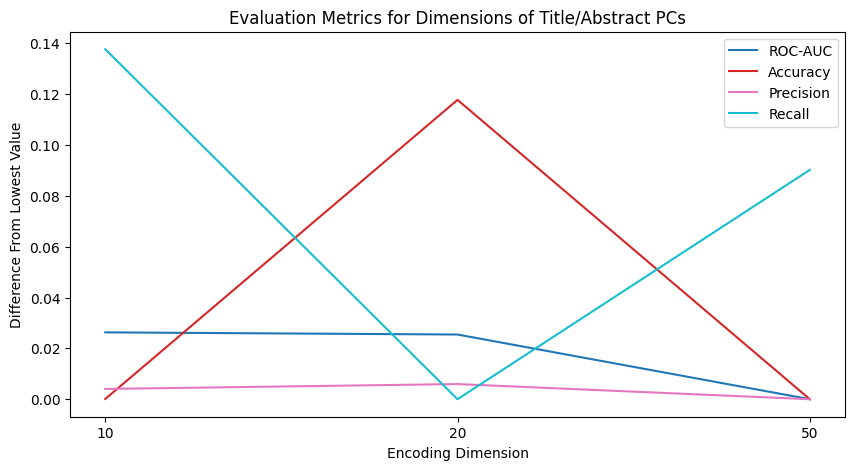

In [164]:
ax = metrics_df_diff.plot(use_index = True,
                   kind = 'line',
                   stacked = False,
                   title = 'Evaluation Metrics for Dimensions of Title/Abstract PCs',
                   xlabel = 'Encoding Dimension',
                   ylabel = 'Difference From Lowest Value',
                   figsize = (10,5),
                   rot = 0,
                   colormap = 'tab10');

labels = list(metrics_df_diff.index)
xticks = [labels.index(d) for d in labels]
ax.set_xticks(xticks)
plt.show()

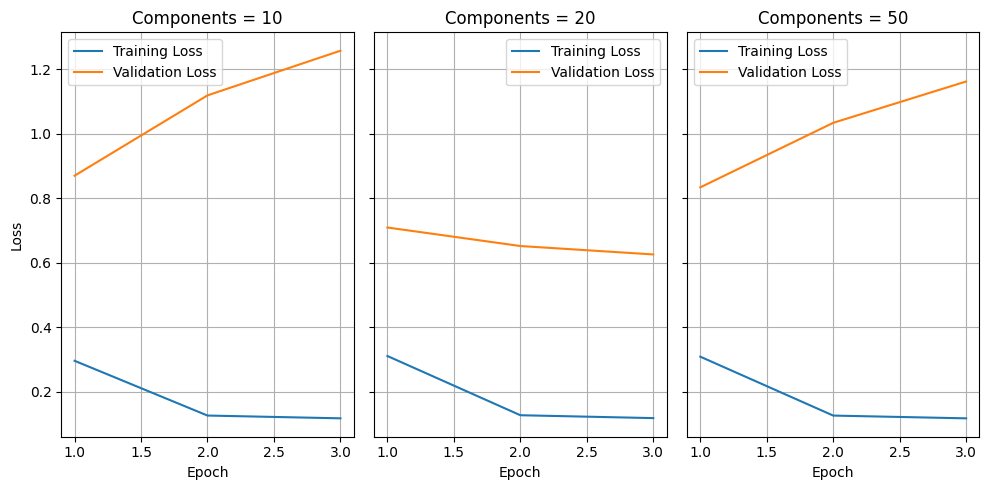

In [170]:
fig, axs = plt.subplots(1, 3, figsize = (10,5), sharey = True)
dims = [10, 20, 50]

for i, dim in enumerate(dims):
    t_loss = loss[dim]
    v_loss = val_loss[dim]
    epochs = range(1, len(t_loss) + 1)
    
    axs[i].plot(epochs, t_loss, label = 'Training Loss')
    axs[i].plot(epochs, v_loss, label = 'Validation Loss')
    axs[i].set_title(f'Components = {dim}')
    axs[i].set_xlabel('Epoch')
    if i == 0: axs[i].set_ylabel('Loss')
    axs[i].legend()
    axs[i].grid(True)
    
plt.tight_layout()
plt.show()